# Import the Libraries

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

# Using random shuffle to create a Train and Test Directories for Normal and Tuberculosis

In [16]:
import os
import shutil
import random

# Set the directories for the original data and the new train/test data
original_data_dir = "/kaggle/input/tuberculosis-tb-chest-x-ray-cleaned-database/TB Chest Radiography Database/Cleaned Data"
train_dir = "/kaggle/input/tuberculosis-tb-chest-x-ray-cleaned-database/TB Chest Radiography Database/Cleaned Data/Train/"
test_dir = "/kaggle/input/tuberculosis-tb-chest-x-ray-cleaned-database/TB Chest Radiography Database/Cleaned Data/Test/"

# Set the subdirectories within the original data directory
normal_dir = os.path.join(original_data_dir, "Normal")
tb_dir = os.path.join(original_data_dir, "Tuberculosis")

# Create the train and test subdirectories within each subdirectory
normal_train_dir = os.path.join(train_dir, "Normal")
normal_test_dir = os.path.join(test_dir, "Normal")
tb_train_dir = os.path.join(train_dir, "Tuberculosis")
tb_test_dir = os.path.join(test_dir, "Tuberculosis")

os.makedirs(normal_train_dir, exist_ok=True)
os.makedirs(normal_test_dir, exist_ok=True)
os.makedirs(tb_train_dir, exist_ok=True)
os.makedirs(tb_test_dir, exist_ok=True)

# Set the split ratio
split_ratio = 0.7

# Get the list of images in the normal and tuberculosis subdirectories
normal_images = os.listdir(normal_dir)
tb_images = os.listdir(tb_dir)

# Shuffle the list of images
random.shuffle(normal_images)
random.shuffle(tb_images)

# Calculate the number of images for the training and testing data
normal_train_num = int(len(normal_images) * split_ratio)
tb_train_num = int(len(tb_images) * split_ratio)

# Copy the normal images to the train and test directories
for i, image in enumerate(normal_images):
    if i < normal_train_num:
        src = os.path.join(normal_dir, image)
        dst = os.path.join(normal_train_dir, image)
        shutil.copy(src, dst)
    else:
        src = os.path.join(normal_dir, image)
        dst = os.path.join(normal_test_dir, image)
        shutil.copy(src, dst)

# Copy the tuberculosis images to the train and test directories
for i, image in enumerate(tb_images):
    if i < tb_train_num:
        src = os.path.join(tb_dir, image)
        dst = os.path.join(tb_train_dir, image)
        shutil.copy(src, dst)
    else:
        src = os.path.join(tb_dir, image)
        dst = os.path.join(tb_test_dir, image)
        shutil.copy(src, dst)


# Load and preprocess the data


In [17]:
# Load and preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    classes=['Normal', 'Tuberculosis'])

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    classes=['Normal', 'Tuberculosis'])

Found 5501 images belonging to 2 classes.

Found 3082 images belonging to 2 classes.


# Adding model layer

In [18]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


# Set up EarlyStopping


In [19]:
# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model


In [20]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples/train_generator.batch_size,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples/test_generator.batch_size,
                    callbacks=[early_stopping])

Epoch 1/10

171/171 [==============================] - 78s 354ms/step - loss: 0.3088 - accuracy: 0.8887 - val_loss: 2.6030 - val_accuracy: 0.4416

Epoch 2/10

171/171 [==============================] - 62s 364ms/step - loss: 0.1504 - accuracy: 0.9446 - val_loss: 1.0483 - val_accuracy: 0.6583

Epoch 3/10

171/171 [==============================] - 60s 349ms/step - loss: 0.1008 - accuracy: 0.9658 - val_loss: 0.1558 - val_accuracy: 0.9354

Epoch 4/10

171/171 [==============================] - 60s 350ms/step - loss: 0.0872 - accuracy: 0.9691 - val_loss: 1.6844 - val_accuracy: 0.6862

Epoch 5/10

171/171 [==============================] - 81s 474ms/step - loss: 0.0825 - accuracy: 0.9682 - val_loss: 1.4152 - val_accuracy: 0.6713

Epoch 6/10

172/171 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9780Restoring model weights from the end of the best epoch: 3.

171/171 [==============================] - 60s 351ms/step - loss: 0.0639 - accuracy: 0.9780 - val_loss: 0.607

# Evaluate the model on the test data


In [21]:
# Evaluate the model on the test data
score = model.evaluate(test_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15579847991466522

Test accuracy: 0.9354315400123596


# Plot the training and validation accuracy


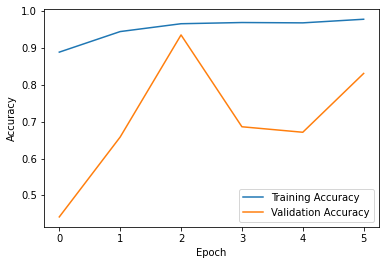

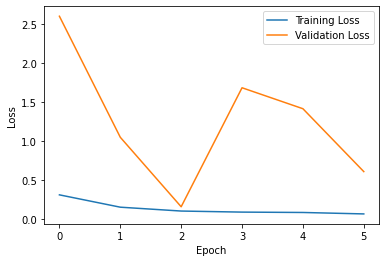

In [24]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the trained model


In [25]:
# Save the trained model
model.save('model.h5')

# Load an example image for Prediction


In [37]:
import cv2
import numpy as np

# Load an example image
image_path = '/kaggle/input/tuberculosis-tb-chest-x-ray-cleaned-database/TB Chest Radiography Database/Cleaned Data/Test/Tuberculosis/Tuberculosis-100.png'
try:
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError('Failed to read image')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image / 255.0

    # Make a prediction on the image using the trained model
    prediction = model.predict(np.array([image]))
    class_index = np.argmax(prediction[0])
    class_label = list(train_generator.class_indices.keys())[class_index]

    print(f'Predicted class: {class_label}')

except Exception as e:
    print(f'Error loading image: {e}')


1/1 [==============================] - 0s 148ms/step

Predicted class: Tuberculosis
